# 드라이브 마운트

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pwd


/content


In [5]:
%cd /content/drive/MyDrive/Study/NLP/밑딥2/deep-learning-from-scratch-2

/content/drive/MyDrive/Study/NLP/밑딥2/deep-learning-from-scratch-2


In [6]:
!ls

ch01  ch03  ch05  ch07	common	   dataset			LICENSE.md
ch02  ch04  ch06  ch08	cover.png  equations_and_figures_2.zip	README.md


# 3.1 추론 기반 기법과 신경망


## 3.1.1 통계 기반 기법의 문제점

말뭉치가 커지면서 어휘의 수가 늘어나게 되면 통계 기반 기법에서는 거대한 행렬을 만들게 되므로 컴퓨팅 자원이 부족한 문제가 생긴다. 
=> 이것을 추론기반기법의 미니배치를 사용하는 특성을 통해서 해결

In [7]:
import numpy as np

c=np.array([[1,0,0,0,0,0,0]]) # 입력 : one-hot vector
W=np.random.randn(7,3) # 임의의 가중치 설정
h=np.matmul(c,W) # 중간 노드 (은닉층)

print(h)

[[-1.47296487  1.31537399 -0.73462518]]


In [8]:
import numpy as np
from common.layers import MatMul

c=np.array([[1,0,0,0,0,0,0]])
W=np.random.randn(7,3)
layer=MatMul(W)
h=layer.forward(c)
print(h)

[[ 1.61043951 -1.28438188 -0.47083751]]


# 3.2 단순한 word2vec

## 3.2.1 CBOW 모델의 추론 처리

* CBOW모델은 맥락(주변단어)으로부터 타깃(중앙단어)을 추측하는 용도의 신경망

In [9]:
import numpy as np
from common.layers import MatMul

# 샘플 맥락 데이터
c0=np.array([[1,0,0,0,0,0,0]])
c1=np.array([[0,0,1,0,0,0,0]])

# 가중치 초기화
W_in=np.random.randn(7,3)
W_out=np.random.randn(3,7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1=MatMul(W_in)
out_layer=MatMul(W_out)

# 순전파
h0=in_layer0.forward(c0)
h1=in_layer1.forward(c1)
h=0.5*(h0+h1)
s=out_layer.forward(h)

print(s)


[[-0.1627274  -1.72122584  1.78975404 -0.4385884   0.77327797  1.99742448
  -1.04189078]]


## 3.2.2 CBOW 모델의 학습

맥락(전후 단어)이 주어졌을 때 그 중앙에 어떤 단어가 출현하는지를 나타내는 점수가 출력층에서 출력된다.

# 3.3 학습 데이터 준비

## 3.3.1 맥락과 타깃

CBOW : word2vec에서 이용하는 신경망의 입력은 '맥락'입니다. 그리고 그 정답 레이블은 맥락에 둘러싸인 중앙의 단어, 즉 '타깃'입니다. 다시 말해, 우리가 해야 할 일은 신경망에 '맥락'을 입력했을 때 '타깃'이 출현할 확률을 높이는 것입니다. 

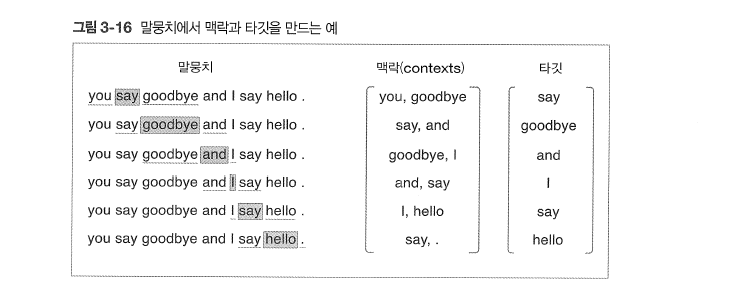

ex) say에 대한 맥락은 window_size가 1인 경우, you, goodbye

* 말뭉치 텍스트에서 contexts, target 추출

In [10]:
from common.util import preprocess
text= 'You say goodbye and I say hello.'
corpus, word_to_id,id_to_word=preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [11]:
corpus[1:-1] # target. 양쪽 끝의 단어는 제외.

array([1, 2, 3, 4, 1, 5])

In [12]:
def create_contexts_target(corpus,window_size=1):
  target=corpus[window_size:-window_size] # 양쪽 끝 단어를 제외한 타겟들
  contexts=[]

  for idx in range(window_size,len(corpus)-window_size):
    cs=[]
    for t in range(-window_size,window_size+1): # 양쪽 window 만큼 단어를 포함  ( 1인 경우, 왼쪽으로 1, 오른쪽으로 1)
      if t==0: # target은 제외
        continue
      cs.append(corpus[idx+t])
    contexts.append(cs)


  return np.array(contexts),np.array(target)

In [13]:
contexts,target= create_contexts_target(corpus,window_size=1)
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


* One hot vector로 변환. (신경망에 알맞게 변환)

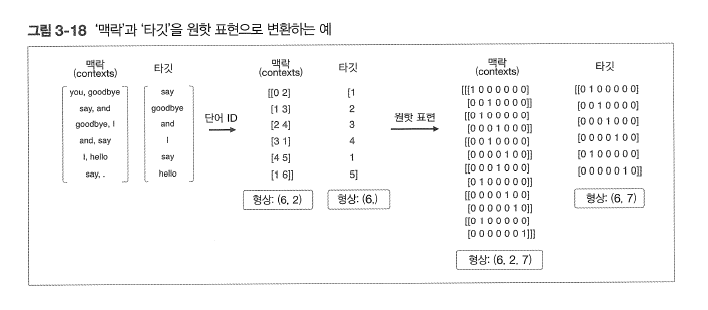

In [14]:
from common.util import preprocess, create_contexts_target, convert_one_hot
text ='You say goodbye and I say hello.'
corpus,word_to_id,id_to_word=preprocess(text)

contexts, target= create_contexts_target(corpus,window_size=1)

vocab_size=len(word_to_id)
target=convert_one_hot(target,vocab_size) # label 
contexts=convert_one_hot(contexts,vocab_size) # input


print(target)
print(target.shape)
print(contexts)
print(contexts.shape)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
(6, 7)
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]
(6, 2, 7)


# 3.4 CBOW 모델 구현

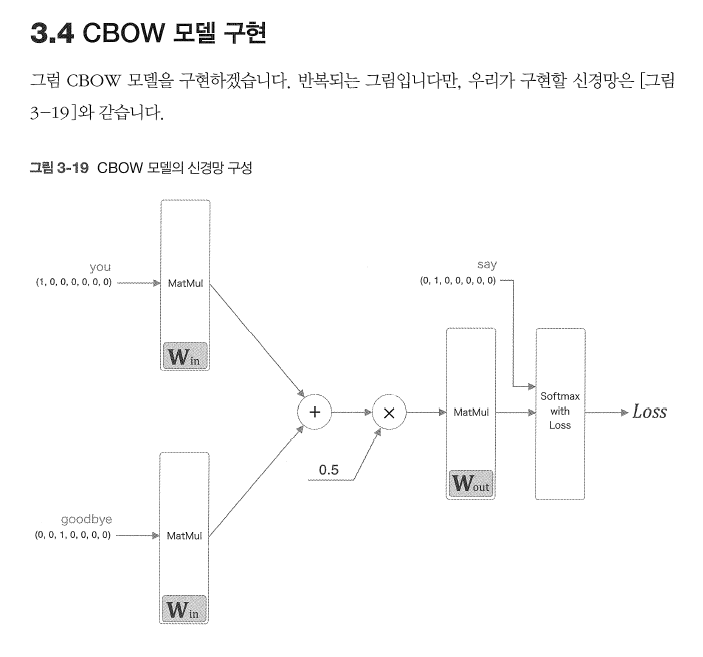

In [20]:
from common.layers import MatMul, SoftmaxWithLoss

class SImpleCBOW:
  def __init__(self,vocab_size,hidden_size):
    V,H=vocab_size,hidden_size

    # 가중치 초기화 
    W_in=0.01*np.random.randn(V,H).astype('f')
    W_out=0.01*np.random.randn(H,V).astype('f')

    # 계층 생성 : 입력측의 맥락을 처리하는 Matmul 계층은 맥락에서 사용하는 단어의 수 (윈도우 크기)만큼 만들어야함.
    self.in_layer0=MatMul(W_in) # 입력측의 MatMul 계층들은 모두 같은 가중치를 이용하도록 초기화
    self.in_layer1=MatMul(W_in)
    self.out_layer=MatMul(W_out)
    self.loss_layer=SoftmaxWithLoss()

    # 모든 가중치와 기울기를 리스트에 모은다.
    layers=[self.in_layer0,self.in_layer1,self.out_layer]
    self.params,self.grads=[],[]

    for layer in layers:
      self.params+=layer.params
      self.grads +=layer.grads

    # 인스턴스 변수에 단어의 분산 표현을 저장한다.
    self.word_vecs=W_in

 # 이 부분이 앞 챕터와 다른부분

  def forward(self, contexts, target):
    h0=self.in_layer0.forward(contexts[:,0])
    h1=self.in_layer1.forward(contexts[:,1])
    h=(h0+h1)*0.5
    score=self.out_layer.forward(h)
    loss=self.loss_layer.forward(score,target)
    return loss

  def backward(self,dout=1):
    ds=self.loss_layer.backward(dout)
    da=self.out_layer.backward(ds)
    da*=0.5
    self.in_layer1.backward(da)
    self.in_layer0.backward(da)
    return None

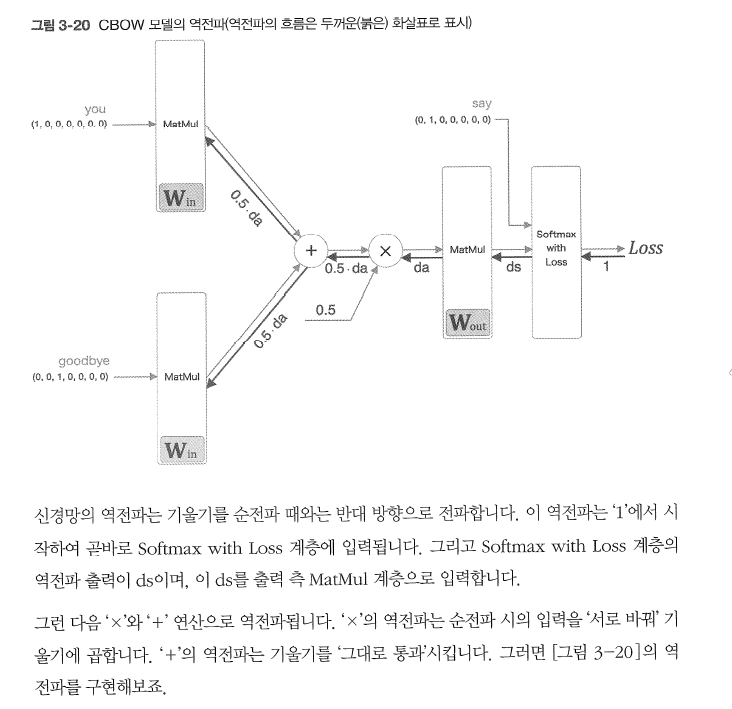

## 3.4.1 학습코드 구현

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_te

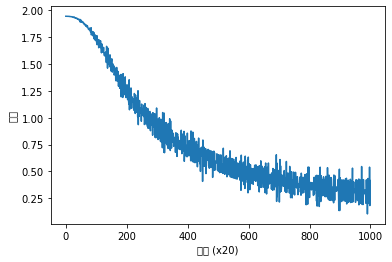

In [21]:
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target,convert_one_hot
window_size=1
hidden_size=5
batch_size=3
max_epoch=1000

text='You say goodbye and I say hello.'
corpus, word_to_id,id_to_word=preprocess(text)

vocab_size=len(word_to_id)
contexts,target=create_contexts_target(corpus,window_size)
target=convert_one_hot(target,vocab_size)
contexts=convert_one_hot(contexts,vocab_size)

model=SImpleCBOW(vocab_size,hidden_size)
optimizer=Adam()
trainer=Trainer(model,optimizer)

trainer.fit(contexts,target,max_epoch,batch_size)
trainer.plot()



* SimpleCBOW 모델에서 저장한 W_in값. (즉, 단어 ID의 분산표현 값)

In [22]:
word_vecs=model.word_vecs
for word_id,word in id_to_word.items():
  print(word,word_vecs[word_id])

you [ 1.0324833  -1.6390731  -0.945233   -0.9370174  -0.98192996]
say [ 0.10643009 -0.25817397  1.2692224   1.2710696   1.2643887 ]
goodbye [ 1.017083   0.556232  -0.9703659 -1.0054737 -1.0417098]
and [ 1.6096901 -1.4339147  1.0032799  1.0067372  0.8340859]
i [ 1.0573503  0.5722933 -1.0090138 -1.022709  -1.0736989]
hello [ 1.0248893  -1.6473467  -0.92937064 -0.91280216 -0.96613497]
. [-1.4117337  1.4218     1.1674352  1.1496319  1.1535649]


하지만 이러한 단순한 CBOW 모델은 처리효율 면에서 한계가 있다.

# 3.5 word2vec 보충 ( CBOW 모델의 backward )

## 3.5.1 CBOW 모델과 확률

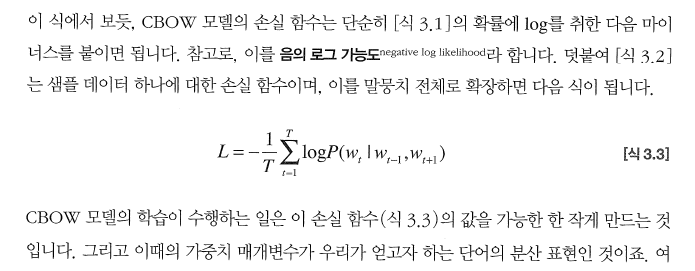

* L 값을 최소화하는 식으로 모델이 학습을 수행.

## 3.5.2 skipgram 모델

* CBOW : 맥락으로 부터 중앙의 단어를 추측
* Skip-gram : 중앙의 단어(타깃)으로부터 주변의 여러 단어(맥락)을 추측함.


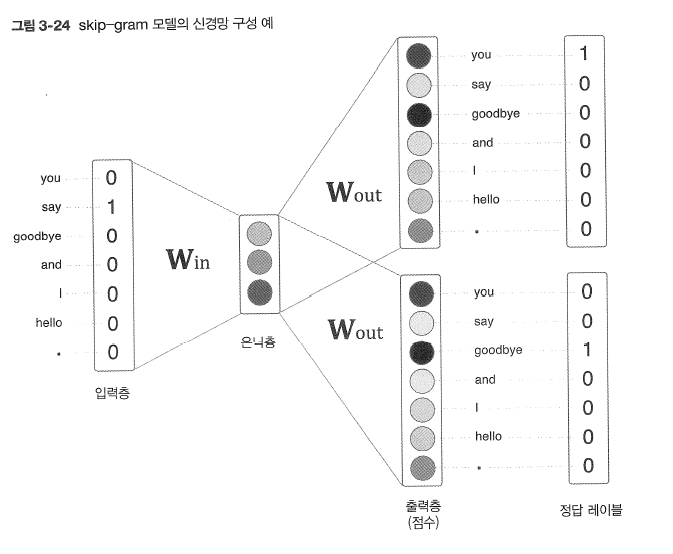

따라서 입력층은 타깃. 하나의 입력만 존재, 맥락의 수만큼 출력층이 존재한다.
각각의 출력층에서 Softmax with Loss 계층을 이용해 손실을 구하고, 이 값을 모두 더해서 최종 손실을 구한다.


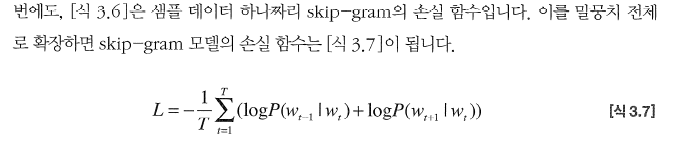

* 단어 분산 표현의 정밀도 면에서 skip-gram 모델의 결과가 더 좋다. 반면, 학습속도 면에서는 CBOW 모델이 더 빠르다.

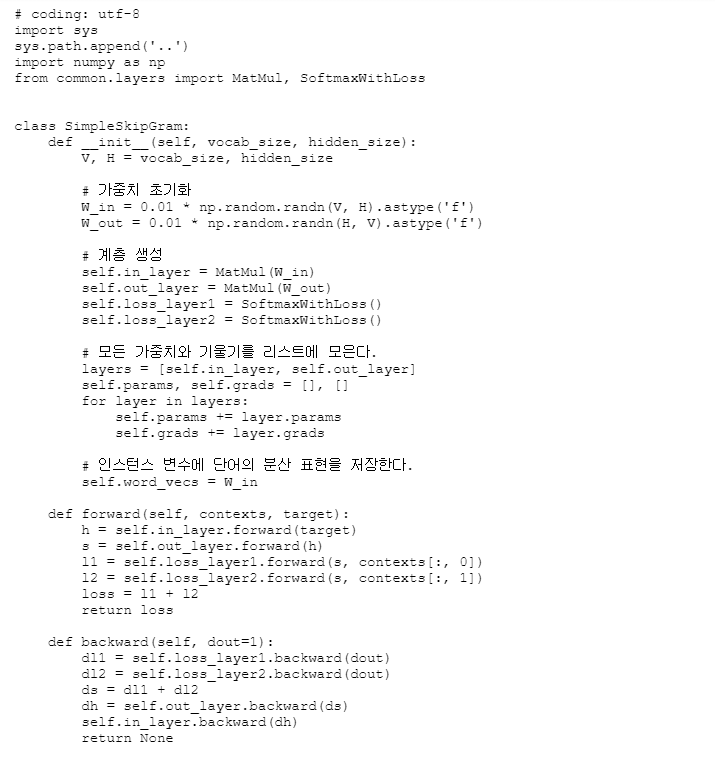

## 3.5.3 통계기반 vs. 추론기반

* 통계 기반 : 

1.   말뭉치의 전체 통계로부터 1회 학습, 따라서 어휘에 추가할 새 단어가 생기면 분산 표현을 갱신해야하는 상황에서, 동시발생행렬, SVD를 수행해야하는 번거로움이 있음.
2.   사실상 우열을 가릴 수 없음.




---

* 추론 기반 :

1.   지금까지 학습한 가중치를 초깃값으로 사용해 다시 학습하면 되므로,
 효율적인 단어의 갱신이 가능하다. 
2.   단어의 유사성은 물론 단어 사이의 복잡한 패턴까지도 파악할 수 있다.



# 3.6 정리

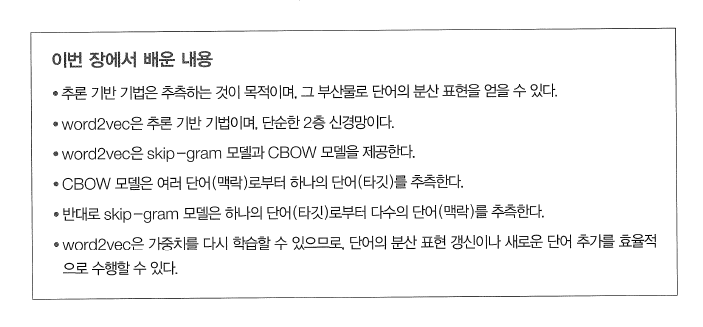